# Random Forest for modelling specific mass balance 

In [5]:
# Import libraries
import pandas as pd
from pandas import read_csv
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import shap
from yellowbrick.regressor import ResidualsPlot

## Import and standardize the data

In [6]:
# Import dataframe
df2000_2020 = pd.read_csv('C:/Users/david/Documents/Thesis/Data/df2000_2020_imp.csv')
numerical = df2000_2020[['velocity_mean','avg_ice_thickness', 'debris_area_ela_p',
       'Slope', 'Aspect', 'Area', 'Zmed', 'ice_volume','debris_vol_ela_p',
       'tstar_aar', 'temp_diff_2000_2020', 'temp_mean_2000_2020',
       'prcp_diff_2000_2020', 'prcp_mean_2000_2020','temp_diff_1980-2000','prcp_diff_1980_2000']]
list_numerical = numerical.columns
df = pd.concat([df2000_2020[['dmdtda','dvoldt', 'glacial_lake','surging']],numerical], axis=1)

# Z-score the independent numerical variables
scaler = StandardScaler().fit(df2000_2020[list_numerical]) 

df[list_numerical] = scaler.transform(df[list_numerical])

df = df.dropna(how='any',axis=0) 

# Set the features (represented as X) and the label (represented as y):
# Labels are the values we want to predict
y = np.array(df['dmdtda'])

X = df[['avg_ice_thickness','Area', 'debris_area_ela_p', 'velocity_mean',
       'Slope', 'Aspect', 'Zmed', 'tstar_aar', 'temp_diff_2000_2020',
       'temp_mean_2000_2020', 'prcp_diff_2000_2020', 'prcp_mean_2000_2020',
       'temp_diff_1980-2000', 'prcp_diff_1980_2000',
                'glacial_lake', 'surging']]

# Saving feature names for later use
feature_list = list(X.columns)

In [7]:
# Using Skicit-learn to split data into training and testing sets
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 94869)

## Tune parameters of Random Forest model with GridSearchCV

In [8]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [20,30],
    'max_features': [9,11],
    'min_samples_leaf': [2,3],
    'min_samples_split': [4,5],
    'n_estimators': [200]
}

# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='neg_mean_squared_error')

In [9]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


{'bootstrap': True,
 'max_depth': 30,
 'max_features': 11,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 200}

## Train Random Forest model

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4394309)

# Import the model we are using
rf = RandomForestRegressor()
rf.set_params(**grid_search.best_params_)

# Train the model on training data
rf.fit(X_train, y_train);

## Make predictions for test set

In [11]:
y_pred = rf.predict(X_test)

In [12]:
mae = np.mean(abs(y_pred - y_test))
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = metrics.r2_score(y_test, y_pred) #Rsquared

# Print out the mean absolute error (mae), R2 and RMSE
print('MAE:',mae)
print('RMSE', rmse)
print('R2:',r2)

MAE: 0.117489028414225
RMSE 0.17788486025124609
R2: 0.6511500396691675


## Compute feature importences with permutation feature importance measure

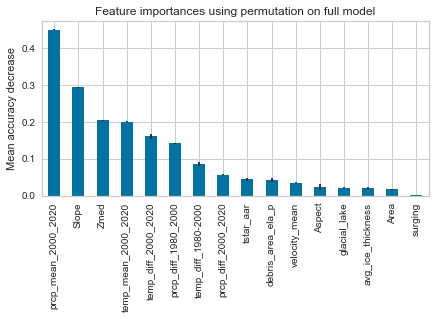

In [229]:
# Run permutation feature importance technique 100 times, and average the results:
result = permutation_importance(
    rf, X, y, n_repeats=100, random_state=58311, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=feature_list)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots()

forest_importances.plot.bar(yerr=result.importances_std, ax=ax)

ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
fig.set_figheight(4)
fig.set_figwidth(6)
plt.show()

In [150]:
forest_importances

prcp_mean_2000_2020    0.465181
Slope                  0.302271
Zmed                   0.214049
temp_mean_2000_2020    0.188562
prcp_diff_1980_2000    0.160096
temp_diff_2000_2020    0.156380
temp_diff_1980-2000    0.085776
debris_area_ela_p      0.052646
prcp_diff_2000_2020    0.052048
tstar_aar              0.043120
velocity_mean          0.031496
Aspect                 0.027245
glacial_lake           0.025831
avg_ice_thickness      0.022118
Area                   0.015921
surging                0.000892
dtype: float64

## Compute feature importences with SHAP measure

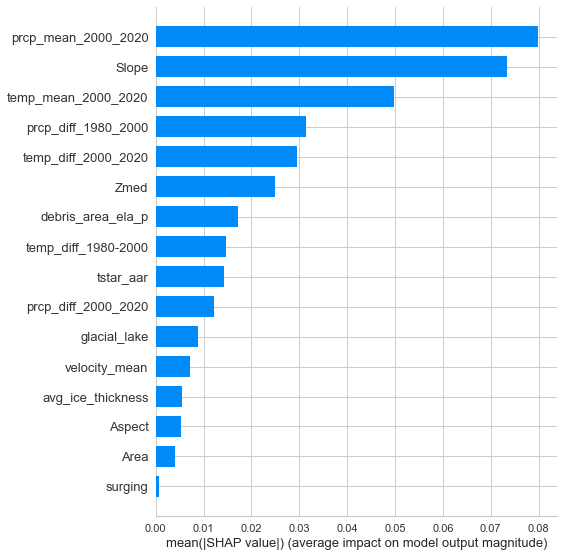

In [183]:
# Get absolute feature importances
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")


In [184]:
# Get absolute feature importances in dataframe
feature_names = X.columns
rf_resultX = pd.DataFrame(shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance

,col_name,feature_importance_vals
11,prcp_mean_2000_2020,0.079909
4,Slope,0.073470
9,temp_mean_2000_2020,0.049875
13,prcp_diff_1980_2000,0.031450
8,temp_diff_2000_2020,0.029572
6,Zmed,0.024983
2,debris_area_ela_p,0.017174
12,temp_diff_1980-2000,0.014768
7,tstar_aar,0.014263
10,prcp_diff_2000_2020,0.012077


## Make beeswarm plot

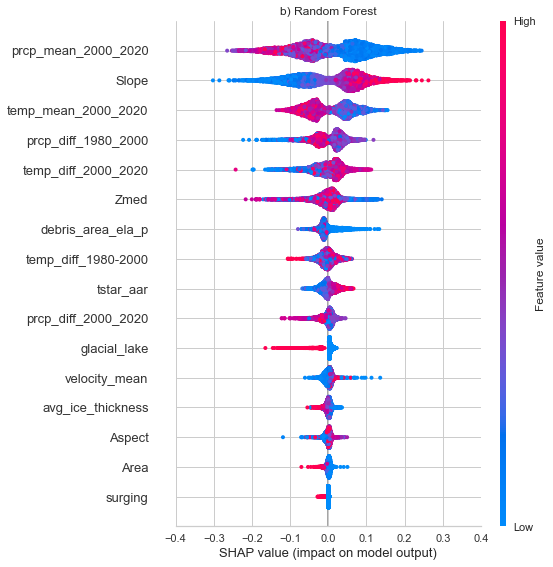

In [193]:
explainer = shap.Explainer(rf)
# Helper procedure
if hasattr(explainer, "expected_value"):
    if type(explainer.expected_value) is np.ndarray:
        explainer.expected_value = explainer.expected_value.mean()
shap_values = explainer(X)

shap.summary_plot(shap_values, X, show=False)

plt.title("b) Random Forest")
plt.xlim(-0.4,0.4)
plt.savefig('SHAP_RF.png', bbox_inches='tight', dpi=300)
plt.show()

## Predicted vs Actual plot

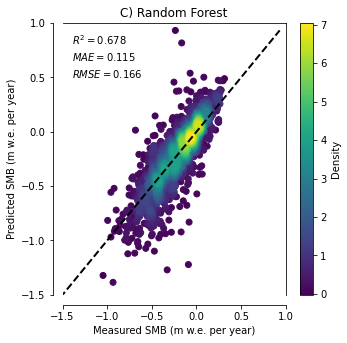

In [122]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots(figsize=(5,5))
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.scatter(x, y, c=z, **kwargs )
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([-1.5,1])
    ax.set_ylim([-1.5,1])
    ax.set_xlabel("Measured SMB (m w.e. per year)")
    ax.set_ylabel("Predicted SMB (m w.e. per year)")
    ax.annotate("$R^2={:.3f}$".format(r2), (-1.4, 0.8))
    ax.annotate("$RMSE={:.3f}$".format(rmse), (-1.4, 0.5))
    ax.annotate("$MAE={:.3f}$".format(mae), (-1.4, 0.65))
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--k", linewidth=2)
    plt.title("C) Random Forest")
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')
    plt.savefig('randomforest.png', bbox_inches='tight', dpi=300)

    return ax


if "__main__" == __name__ :
    density_scatter(y_pred, y_test, bins = [30,30] )

## Plot residuals of Random Forest model

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


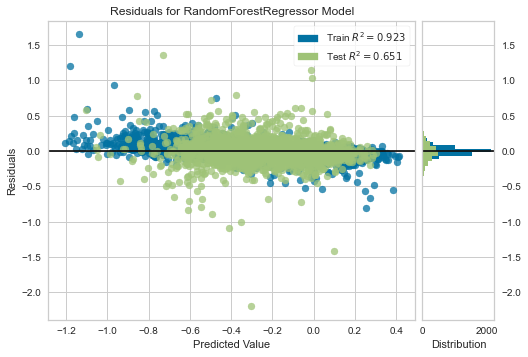

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [14]:
visualizer = ResidualsPlot(rf)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()